# Robot Simulation

In [26]:
from jyro.simulator import (Robot, Pioneer, Pioneer16Sonars, 
                            PioneerFrontLightSensors, Camera,
                            VSimulator, DepthCamera)
import random
import numpy as np

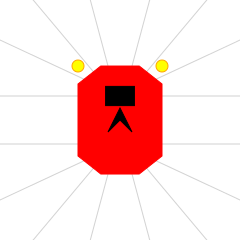

In [27]:
robot = Pioneer("Pioneer", 3.5, 2, 0)
robot.addDevice(Pioneer16Sonars())
robot.addDevice(DepthCamera(4))
light_sensors = PioneerFrontLightSensors(3.0)
light_sensors.lightMode = 'ambient'
robot.addDevice(light_sensors)

In [28]:
def worldf(physics):
    physics.addBox(0, 0, 4, 4, fill="backgroundgreen", wallcolor="gray")
    physics.addLight(2, 0.75, 1.0) # increased brightness for new linear version of lights

In [29]:
sim = VSimulator(robot, worldf)

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='248px', padding='0px 0px 0px 0px', width='10px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="240" version="1.1" width="240" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="240.0" stroke="#bebebe" stroke-width="1" width="240.0" x="0.0" y="0.0" /><circle cx="120.0" cy="195.0" fill="#ffff00" r="15.0" stroke="#ffff00" stroke-width="1" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="109.80000000000001" y2="16.07215199999999" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.77724019461742" y1="107.99999999999999" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="106.5" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="106.5" y2="5.734632000000062" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="107.99999999999999" y2="80.11296600000001" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="109.80000000000001" y2="100.007538" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="130.2" y2="139.992462" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="132.0" y2="159.88703399999997" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="133.5" y2="234.26536799999994" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="133.5" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.7772401946174" y1="132.0" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="130.2" y2="223.927848" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="2.1539193796210117" y1="120.0" y2="0.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="240.0" y1="120.0" y2="102.67948799999999" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="199.5" y1="195.0" y2="106.5" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="220.5" y1="195.0" y2="106.5" /><polygon fill="red" points="205.2,106.5 199.5,111.0 199.5,129.0 205.2,133.5 214.8,133.5 220.5,129.0 220.5,111.0 214.8,106.5" stroke="red" stroke-width="1" /><polygon points="-3.0,-3.0 0,0 3.0,-3.0 0,3.0" stroke="black" stroke-width="1" transform="translate(210.0,120.0) rotate(180.0)" /><polygon fill="black" points="213.6,111.6 213.6,116.39999999999999 206.4,116.39999999999999 206.4,111.6" stroke="black" stroke-width="1" /><circle cx="199.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /><circle cx="220.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='30px', padding='0px 0px 0px 10px', width='260px'), readout=False))), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAP////Ly8uXl5dra2tnZ2djY2NfX19bW1tXV1dPT09LS0tDQ0M/Pz83NzczMzMrKysjIyMXFxcLCwr+/v76+vrm5ubS0tLKysq6urqenp6WlpZ6enpmZmZOTk4yMjIWFhX9/f35+fn19fXx8fHp6enl5eXd3d3Z2dnR0dHJycnFxcW9vb2xsbGl

In [30]:
camera = robot.device["camera"]

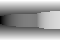

In [31]:
image = camera.getImage()
image

In [32]:
image.size

(60, 40)

In [33]:
data = camera.getData()
data.shape

(40, 60, 3)

In [34]:
robot.move(0.50, 0.35)

In [35]:
sim.step()

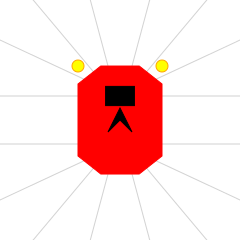

In [36]:
robot = Pioneer("Pioneer", 3.5, 2, 0)
robot.addDevice(Pioneer16Sonars())
robot.addDevice(Camera())
light_sensors = PioneerFrontLightSensors(3.0)
light_sensors.lightMode = 'ambient'
robot.addDevice(light_sensors)

In [39]:
sim = VSimulator(robot, worldf)

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='248px', padding='0px 0px 0px 0px', width='10px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="240" version="1.1" width="240" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="240.0" stroke="#bebebe" stroke-width="1" width="240.0" x="0.0" y="0.0" /><circle cx="120.0" cy="195.0" fill="#ffff00" r="15.0" stroke="#ffff00" stroke-width="1" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="109.80000000000001" y2="16.07215199999999" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.77724019461742" y1="107.99999999999999" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="106.5" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="106.5" y2="5.734632000000062" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="107.99999999999999" y2="80.11296600000001" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="109.80000000000001" y2="100.007538" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="114.0" y2="114.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="220.5" x2="240.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="219.0" x2="240.0" y1="130.2" y2="139.992462" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="216.6" x2="240.0" y1="132.0" y2="159.88703399999997" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="213.0" x2="240.0" y1="133.5" y2="234.26536799999994" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="207.0" x2="178.4634099424212" y1="133.5" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="203.4" x2="112.7772401946174" y1="132.0" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="201.0" x2="0.0" y1="130.2" y2="223.927848" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="199.5" x2="0.0" y1="126.0" y2="126.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="2.1539193796210117" y1="120.0" y2="0.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="210.0" x2="240.0" y1="120.0" y2="102.67948799999999" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="199.5" y1="195.0" y2="106.5" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="120.0" x2="220.5" y1="195.0" y2="106.5" /><polygon fill="red" points="205.2,106.5 199.5,111.0 199.5,129.0 205.2,133.5 214.8,133.5 220.5,129.0 220.5,111.0 214.8,106.5" stroke="red" stroke-width="1" /><polygon points="-3.0,-3.0 0,0 3.0,-3.0 0,3.0" stroke="black" stroke-width="1" transform="translate(210.0,120.0) rotate(180.0)" /><polygon fill="black" points="213.6,111.6 213.6,116.39999999999999 206.4,116.39999999999999 206.4,111.6" stroke="black" stroke-width="1" /><circle cx="199.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /><circle cx="220.5" cy="106.5" fill="yellow" r="1.5" stroke="orange" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='30px', padding='0px 0px 0px 10px', width='260px'), readout=False))), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5rOzs7KysrGxsbCwsK+vr66urq2traysrKurq6qqqqmpqaenp6ampqOjo6GhoZ6enpmZmZeXl5aWlpWVlZSUlJOTk5KSkpGRkZCQkI+Pj46OjoyMjIuLi4mJiYeHh4WFhYODg4CAgH19fXp6enZ2dnJycgAAAAAAAAAAAAAAAAAAAAA

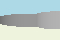

In [40]:
camera = robot.device["camera"]
image = camera.getImage()
image

In [41]:
data = camera.getData()
data.shape

(40, 60, 3)

In [42]:
def random_action():
    """Generate a random action from a limited set of possible settings"""
    possible = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return [random.choice(possible), random.choice(possible)]

def get_senses(robot):
    light = robot["light"].getData()
    sonar = [v/3.0 for v in robot["sonar"].getData()]
    camera = robot["camera"].getData()
    return [light, sonar, camera]

In [43]:
senses = get_senses(robot)
list(map(len, senses))

[2, 16, 40]

In [44]:
def brain(robot):
    senses = get_senses(robot)
    net.propagate(senses)
    translate, rotate = random_action()
    #self.move(translate, rotate)
    robot.move(0.50, 0.35)

In [45]:
robot.brain = brain

In [46]:
from conx import Network, Layer, FlattenLayer, SGD, ImageLayer, Conv2DLayer
import numpy as np

In [47]:
net = Network("Robot Prediction Network")
net.add(Layer("light", 2))
net.add(Layer("sonar", 16))
net.add(ImageLayer("camera", (40,60), 3))
net.add(FlattenLayer("flatten"))
net.add(Conv2DLayer("conv", 16, (3,3)))
net.add(Layer("hidden", 50, activation="relu"))
net.add(Layer("output1", 2, activation="sigmoid"))
net.add(Layer("hidden2", 5, activation="sigmoid"))
net.add(Layer("hidden3", 10, activation="sigmoid", dropout=0.25))
net.add(Layer("hidden4", 10, activation="sigmoid"))
net.add(Layer("output2", 5, activation="sigmoid"))

In [48]:
net.connect("sonar", "hidden2")
net.connect("light", "hidden")
net.connect("camera", "conv")
net.connect("conv", "flatten")
net.connect("flatten", "hidden2")
net.connect("hidden", "hidden2")
net.connect("hidden2", "hidden3")
##net.connect("hidden2", "output2")
net.connect("hidden3", "output2")
net.connect("hidden3", "hidden4")
net.connect("hidden4", "output1")

In [49]:
net.compile(optimizer="adam", error="mse")
#net.config["hspace"] = 200

<IPython.core.display.Javascript object>

<Network name='Robot Prediction Network' (compiled)>
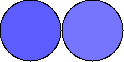
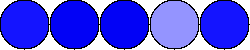
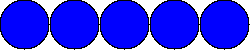
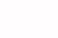
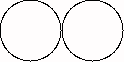
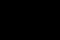

In [50]:
net

In [51]:
matrix = net.propagate_to("conv", get_senses(robot))

In [52]:
net["conv"].feature = 6


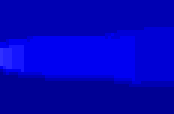
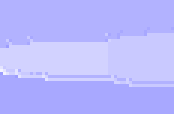
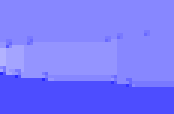
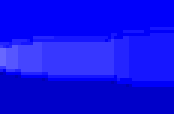
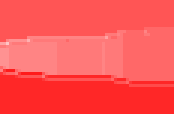
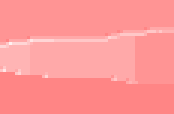
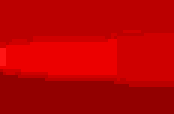
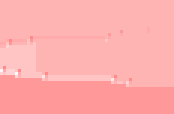
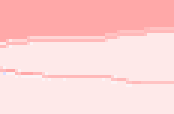
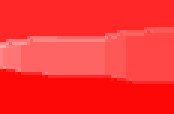
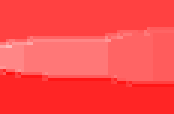
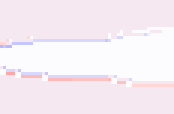
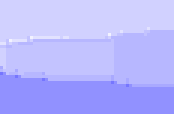
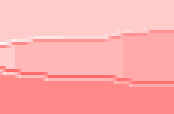
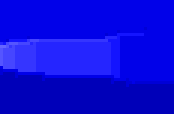
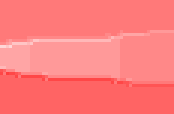

In [53]:
net.propagate_to_features("conv", get_senses(robot), scale=3)

In [54]:
net.dataset.add([[0] * 2, [0] * 16, data], [[0] * 2, [1] + ([0] * 4)])

In [55]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'camera', 'conv'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=10, options=('light', 'sonar', 'camera', 'flatten', 'conv', 'hidden', 'output1', 'hidden2', 'hidden3', 'hidden4', 'output2'), rows=1, value='output2'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Network name='Robot Prediction Network' (compiled)>
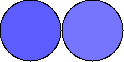
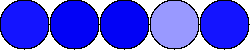
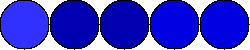
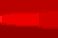
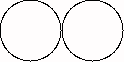
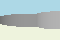

In [56]:
net

In [57]:
net.test()

Testing validation dataset with tolerance 0.1...
Total count: 1
      correct: 0
      incorrect: 1
Total percentage correct: 0.0


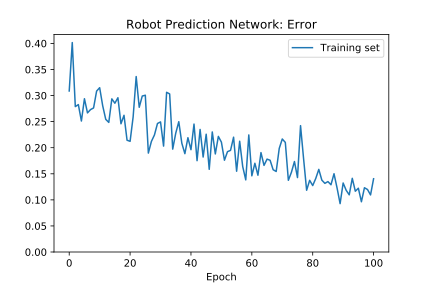

       |  Training |   output1 |   output2 
Epochs |     Error |       acc |       acc 
------ | --------- | --------- | --------- 
#  100 |   0.14043 |   0.00000 |   0.00000 


In [58]:
net.train(epochs=100, plot=True)

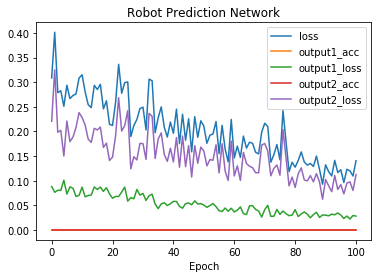

In [59]:
net.plot("all")

In [60]:
net.test(show=True)

Testing validation dataset with tolerance 0.1...
# | inputs | targets | outputs | result
---------------------------------------
0 | [[0.00,0.00],[0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00, 0.00],[[[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,  [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], [[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,  [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], [[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,  [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], ..., [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,  [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]], [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,  [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]], [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,  [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]]]] | [[0.00,0.00],[1.00,0.00,0.00,0.00,0.